## Nouvelle tentative de AlexNet architecture

In [3]:
# import PyTorch and its related packages
import torch as T
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchvision import transforms
from torchvision.datasets import ImageFolder

# set default device based on CUDA's availability
device = 'cuda' if T.cuda.is_available() else 'cpu'
device

'cuda'

In [4]:
transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

batch_size = 64

train_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_33_species/TRAIN/', transform=transform)
test_set = ImageFolder('C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_33_species/TEST/', transform=transform)
# put here the path to your train folder and the path to your test (or validation) folder

train_loader = T.utils.data.DataLoader(train_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


test_loader = T.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

In [5]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=33):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.1),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.2),
            nn.Conv2d(192, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Dropout(p=0.3),
           
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x

In [6]:
net = AlexNet()
net.to(device)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.1, inplace=False)
    (4): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Dropout(p=0.2, inplace=False)
    (8): Conv2d(192, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Dropout(p=0.3, inplace=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace=True)
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4096, out_features=4096, bias=True)
    (5): ReLU(i

In [7]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9) # put here the learning rate you want

In [8]:
train_loss = []
test_loss = []
train_acc = []
test_acc = []

for epoch in range(0, 500):  # put here the number of epochs you want
    
    running_loss = .0
    correct = 0
    total = 0
    for i, data in enumerate(train_loader):
        # get the inputs
        inputs, labels = data
        if device == 'cuda':
            inputs, labels = inputs.to(device), labels.to(device)

        # reset the parameter gradients
        optimizer.zero_grad()

        # forward
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        
        # backward
        loss.backward()
        
        # optimize
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = T.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    running_loss /= len(train_loader)
    train_loss.append(running_loss)
    running_acc = correct / total
    train_acc.append(running_acc)
    
    if epoch % 10 == 0:
        print('\nEpoch: {}'.format(epoch))
        print('Train Acc. => {:.3f}%'.format(100 * running_acc), end=' | ')
        print('Train Loss => {:.5f}'.format(running_loss))
    
    # evaluate on the test set
    # note this is usually performed on the validation set
    # for simplicity we just evaluate it on the test set
    with T.no_grad():
        correct = 0
        total = 0
        test_running_loss = .0
        for data in test_loader:
            inputs, labels = data
            if device == 'cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item()
            _, predicted = T.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        test_running_loss /= len(test_loader)
        test_loss.append(test_running_loss)
        test_running_acc = correct / total
        test_acc.append(test_running_acc)
        
        if epoch % 10 == 0:
            print('Test Acc.  => {:.3f}%'.format(100 * test_running_acc), end=' | ')
            print('Test Loss  => {:.5f}'.format(test_running_loss))

print('Finished Training')


Epoch: 10
Train Acc. => 9.338% | Train Loss => 3.40069
Test Acc.  => 9.442% | Test Loss  => 3.33823

Epoch: 20
Train Acc. => 9.338% | Train Loss => 3.36865
Test Acc.  => 9.442% | Test Loss  => 3.29328

Epoch: 30
Train Acc. => 9.338% | Train Loss => 3.34854
Test Acc.  => 9.442% | Test Loss  => 3.28276

Epoch: 40
Train Acc. => 9.151% | Train Loss => 3.32308
Test Acc.  => 12.124% | Test Loss  => 3.28628

Epoch: 50
Train Acc. => 9.945% | Train Loss => 3.26209
Test Acc.  => 10.086% | Test Loss  => 3.28237

Epoch: 60
Train Acc. => 10.319% | Train Loss => 3.23531
Test Acc.  => 15.665% | Test Loss  => 3.09419

Epoch: 70
Train Acc. => 13.249% | Train Loss => 2.96972
Test Acc.  => 13.627% | Test Loss  => 3.34803

Epoch: 80
Train Acc. => 17.065% | Train Loss => 2.87668
Test Acc.  => 16.416% | Test Loss  => 3.01465

Epoch: 90
Train Acc. => 14.906% | Train Loss => 2.75323
Test Acc.  => 10.408% | Test Loss  => 6.39026

Epoch: 100
Train Acc. => 13.891% | Train Loss => 3.13370
Test Acc.  => 9.442% | 

## Visualization

In [9]:
import matplotlib.pyplot as plt

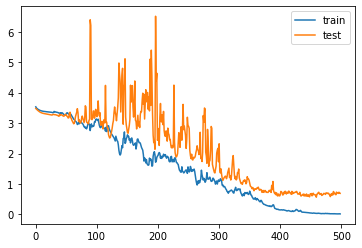

In [10]:
plt.plot(train_loss, label='train')
plt.plot(test_loss, label='test')
plt.legend()
plt.show()

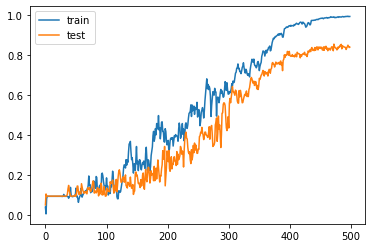

In [11]:
plt.plot(train_acc, label='train')
plt.plot(test_acc, label='test')
plt.legend()
plt.show()

In [14]:
torch.save(net.state_dict(), "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_33_species/dict_Lin_network_33")
# put here your path and the filename you want

In [15]:
torch.save(net, "C:/Users/heuma/Desktop/Master/S10/Aurea/Dataset_Kaggle_Test_Train_33_species/Lin_network_entire_model_33")
# put here your path and the filename you want